1. Document classification with LSTM network:

In [1]:
import pandas as pd
import numpy as np
import warnings    
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.reuters import load_data, get_word_index       # Reuters news data. 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

2025-06-07 08:19:51.877406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 08:19:52.347786: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 08:19:52.721950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749259193.084384    1276 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749259193.182825    1276 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749259193.925719    1276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

1.1. Read in the data:

In [2]:
n_words = 1000                                        # Size of the vocabulary.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words, test_split = 0.3)
n_train_size = X_train.shape[0]

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


In [3]:
# Check for the shapes.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (7859,)
Training data y shape: (7859,)
--------------------------------------------------
Test data X shape: (3369,)
Test data y shape: (3369,)
--------------------------------------------------


1.2. Explore the data:

In [4]:
# Number of unique values of y = Number of categories of the newswires.
n_cat = pd.Series(y_train).nunique()
n_cat

46

In [5]:
# Print out an observation (document) contained in X.
# It is encoded as integers (indices).
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
# Let's check for length of the first 100 documents.
# We notice that the length is not uniform.
print([len(a) for a in X_train[0:100]])

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64]


In [7]:
# Download the dictionary to translate the indices.
my_dict = get_word_index(path='reuters_word_index.json')

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step


In [8]:
# To view the dictionary.
# my_dict

In [9]:
# Exchange the 'key' and 'value'.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [10]:
# Translate each document.
i_news = 10                                        # Document number that can be changed at will.
news = list(pd.Series(X_train[i_news]).apply(lambda x: my_dict_inv[x]))
print(' '.join(news))

the federal gain only growth lt they meeting year reuter company did year an they of of reuter company of of 1987 had of of reuter had profits of pct dlrs


1.3. Data preprocessing:

In [11]:
# Padding: newswire lengths are uniformly matched to maxlen.
# Cut away if longer than maxlen and fill with 0s if shorter than maxlen.
X_train = sequence.pad_sequences(X_train, maxlen = 100)
X_test = sequence.pad_sequences(X_test, maxlen = 100)

In [12]:
# Apply one-hot-encoding to the y variable.
y = np.concatenate([y_train,y_test],axis=0)
y = to_categorical(y,46)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

1.4. Define the model:

In [13]:
n_neurons = 100                   # Neurons within each memory cell.
n_input = 100                     # Dimension of the embeding space. 

In [14]:
# LSTM network model.
my_model = Sequential()
my_model.add(Embedding(n_words, n_input))           # n_words = vocabulary size, n_input = dimension of the embedding space.
my_model.add(LSTM(units=n_neurons, return_sequences=False, input_shape=(None, n_input), activation='tanh'))
my_model.add(Dense(n_cat, activation='softmax'))

2025-06-07 08:23:28.246394: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
# View the summary.
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

1.5. Define the optimier and compile:

In [16]:
n_epochs = 20                      # Number of epochs.
batch_size = 20                    # Size of each batch.
learn_rate = 0.001                 # learning rate.  

In [17]:
# Optimizer and compilation.
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

1.6. Train the model and visualize the history:

In [18]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose = 1)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.3688 - loss: 2.6050 - val_accuracy: 0.4898 - val_loss: 2.0614
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4970 - loss: 2.0236 - val_accuracy: 0.5375 - val_loss: 1.7668
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.5638 - loss: 1.7410 - val_accuracy: 0.5732 - val_loss: 1.6244
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.5984 - loss: 1.5602 - val_accuracy: 0.6310 - val_loss: 1.4735
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.6336 - loss: 1.4578 - val_accuracy: 0.6590 - val_loss: 1.3688
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.6827 - loss: 1.2848 - val_accuracy: 0.6737 - val_loss: 1.2989
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7184 - loss: 1.1427 - val_accuracy: 0.6940 - val_loss: 1.2388
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.7397 - loss: 1.0503 - 

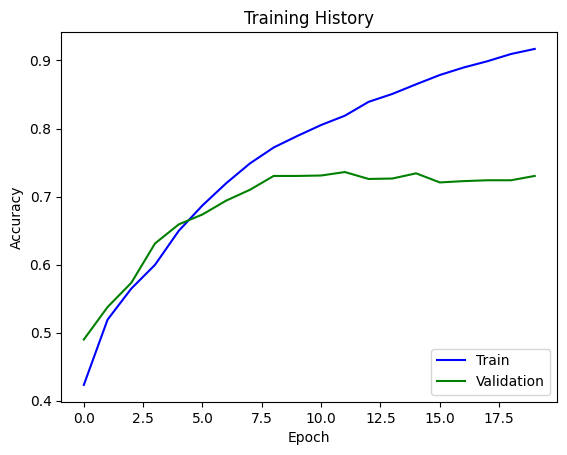

In [19]:
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

1.7. Testing:

In [20]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.705
